In [1]:
import os
import pandas as pd
import numpy as np
from sklearn import preprocessing
import pickle
import matplotlib.pyplot as plt
#import cv2
#import plotly.graph_objs as go
import seaborn as sns
import matplotlib.cm as cm
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
#import mplcursors 
import random
import torch
from scipy.stats import pearsonr
from Utils import load_dict_from_csv

In [110]:
datasets_folder='/media/Blue2TB1'
datasets=['Jin_22','PAMI18','CVPR18','Fan_NOSSDAV_17']
dataset_colors = cm.rainbow(np.linspace(0, 1, len(datasets)))

In [3]:
def plot_SITI(dataset_name,datasets_folder, annotate_all=False, color='blue'):
    dataset_folder=os.path.join(datasets_folder,dataset_name)
    video_img_folder=os.path.join(dataset_folder, 'video_data')
    videos=os.listdir(video_img_folder)
    video_SIs=[]
    video_TIs=[]
    for video in videos:
        array_folder=os.path.join(video_img_folder,video)
        SI = np.load(os.path.join(array_folder, f'{video}_SI.npy'))
        TI = np.load(os.path.join(array_folder, f'{video}_TI.npy'))
        if np.mean(SI)>200:
            print(video)
            print(SI)
            print(np.mean(SI))
            return 0
        # Aggregating based on ITU-T P.910 (10/2023)
        video_SIs.append(np.mean(SI))
        video_TIs.append(np.mean(TI))
    # Plotting the results
    plt.figure(figsize=(10, 6))
    plt.scatter(video_SIs, video_TIs, color=color, marker='o')

    if annotate_all:
        for i, video in enumerate(videos):
            plt.annotate(video, (video_SIs[i], video_TIs[i]))

    plt.title(f'Spatial and Temporal Information for {dataset_name}')
    plt.xlabel('Spatial Information (SI)')
    plt.ylabel('Temporal Information (TI)')
    plt.grid(True)
    
    plots_folder = os.path.join('Plots', 'SITI')
    os.makedirs(plots_folder, exist_ok=True)
    plot_path = os.path.join(plots_folder, f'{dataset_name}_SITI_plot.png')
    plt.savefig(plot_path)
    plt.show()
    

In [4]:
def plot_all_SITI(datasets_folder, datasets, annotate_all=False):
    plt.figure(figsize=(10, 6))
    colors = cm.rainbow(np.linspace(0, 1, len(datasets)))
    global_min_SI, global_max_SI = float('inf'), float('-inf')
    global_min_TI, global_max_TI = float('inf'), float('-inf')
    video_SIs={}
    video_TIs={}
    for idx, dataset_name in enumerate(datasets):
        dataset_folder = os.path.join(datasets_folder, dataset_name)
        video_img_folder = os.path.join(dataset_folder, 'video_data')
        videos = os.listdir(video_img_folder)
        video_SIs[dataset_name] = []
        video_TIs[dataset_name] = []

        for video in videos:
            array_folder = os.path.join(video_img_folder, video)
            SI = np.load(os.path.join(array_folder, f'{video}_SI.npy'))
            TI = np.load(os.path.join(array_folder, f'{video}_TI.npy'))
            mean_SI, mean_TI=np.mean(SI),np.mean(TI)
            global_min_SI = min(global_min_SI, mean_SI)
            global_max_SI = max(global_max_SI, mean_SI)
            global_min_TI = min(global_min_TI, mean_TI)
            global_max_TI = max(global_max_TI, mean_TI)
            # Aggregating based on ITU-T P.910 (10/2023)
            
            video_SIs[dataset_name].append(mean_SI)
            video_TIs[dataset_name].append(mean_TI)
    
    for idx, dataset_name in enumerate(datasets):
        plt.figure(figsize=(12, 6))

        plt.scatter(video_SIs[dataset_name], video_TIs[dataset_name], color=colors[idx], label=dataset_name)

        if annotate_all:
            for i, video in enumerate(videos):
                plt.annotate(video, (video_SIs[i], video_TIs[i]), fontsize=8, color=colors[idx])

        plt.title(f'Spatial and Temporal Information for {dataset_name}')
        plt.xlabel('Spatial Information (SI)')
        plt.ylabel('Temporal Information (TI)')
        plt.legend()
        plt.xlim(0, global_max_SI+5)
        plt.ylim(0, global_max_TI+5)
        plt.grid(True)
        plots_folder = os.path.join('Plots', 'SITI')
        os.makedirs(plots_folder, exist_ok=True)
        plot_path = os.path.join(plots_folder, f'{dataset_name}_SITI_plot.png')
        plt.savefig(plot_path)
        plt.show()

In [5]:
#plot_all_SITI(datasets_folder,datasets)

In [6]:
def fetch_c_entropies(datasets_folder, dataset):
    dataset_folder = os.path.join(datasets_folder, dataset)
    video_img_folder = os.path.join(dataset_folder, '5fps_Video_Images')
    data_path = os.path.join(dataset_folder, 'video_data')
    videos = os.listdir(video_img_folder)
    entropies = {}
    
    for video in videos:
        entropy_path = os.path.join(data_path, video, f'{video}_content_entropy.npy')
        
        if os.path.exists(entropy_path):
            entropy = np.load(entropy_path)
            entropies[video] = entropy
            
    return entropies

In [7]:
def plot_mean_entropy_vs_SITI(datasets_folder, dataset):
    dataset_folder = os.path.join(datasets_folder, dataset)

    data_path = os.path.join(dataset_folder, 'video_data')
    
    videos = os.listdir(data_path)
    mean_SIs = []
    mean_TIs = []
    mean_entropies = []
    
    for video in videos:
        # Load SI and TI values
        array_folder = os.path.join(data_path, video)
        SI_path = os.path.join(array_folder, 'video_SI.npy')
        TI_path = os.path.join(array_folder, 'video_TI.npy')
        
        if os.path.exists(SI_path) and os.path.exists(TI_path):
            SI = np.load(SI_path)
            TI = np.load(TI_path)
            mean_SIs.append(np.mean(SI))
            mean_TIs.append(np.mean(TI))
        
        # Load content entropy values
        entropy_path = os.path.join(data_path, video, f'{video}_content_entropy.npy')
        
        if os.path.exists(entropy_path):
            entropy = np.load(entropy_path)
            mean_entropies.append(np.mean(entropy))
    
    # Determine vmin and vmax for the colormap to handle outliers
    vmin = np.percentile(mean_entropies, 5)
    vmax = np.percentile(mean_entropies, 95)
    
    # Plot mean SI vs mean TI with content entropy as colormap
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(mean_SIs, mean_TIs, c=mean_entropies, cmap='coolwarm', marker='o', vmin=vmin, vmax=vmax)
    
    plt.title(f'Mean TI vs Mean SI with Content Entropy for {dataset}')
    plt.xlabel('Mean Spatial Information (SI)')
    plt.ylabel('Mean Temporal Information (TI)')
    colorbar = plt.colorbar(scatter, label='Mean Content Entropy')
    plt.grid(True)
    plt.tight_layout()
    plots_folder = os.path.join('Plots', 'SITI_entropy')
    os.makedirs(plots_folder, exist_ok=True)
    plot_path = os.path.join(plots_folder, f'{dataset}_SITI_with_entropy_plot.png')
    plt.savefig(plot_path)
    plt.show()

In [106]:
def plot_mean_entropy_vs_SITI_alldatasets(datasets_folder, datasets,fontsize=12,markersize=5):
    global_min_SI, global_max_SI = float('inf'), float('-inf')
    global_min_TI, global_max_TI = float('inf'), float('-inf')
    video_SIs={}
    video_TIs={}
    video_CEs={}

    for idx, dataset_name in enumerate(datasets):
        dataset_folder = os.path.join(datasets_folder, dataset_name)
        video_img_folder = os.path.join(dataset_folder, 'video_data')
        videos = os.listdir(video_img_folder)
        video_SIs[dataset_name] = []
        video_TIs[dataset_name] = []
        video_CEs[dataset_name]=[]
        for video in videos:
            array_folder = os.path.join(video_img_folder, video)
            SI = np.load(os.path.join(array_folder, f'{video}_SI.npy'))
            TI = np.load(os.path.join(array_folder, f'{video}_TI.npy'))
            CE=np.load(os.path.join(array_folder,f'{video}_content_entropy.npy'))
            mean_SI, mean_TI, mean_CE=np.mean(SI),np.mean(TI),np.mean(CE)
            global_min_SI = min(global_min_SI, mean_SI)
            global_max_SI = max(global_max_SI, mean_SI)
            global_min_TI = min(global_min_TI, mean_TI)
            global_max_TI = max(global_max_TI, mean_TI)
            # Aggregating based on ITU-T P.910 (10/2023)
            
            video_SIs[dataset_name].append(mean_SI)
            video_TIs[dataset_name].append(mean_TI)
            video_CEs[dataset_name].append(mean_CE)
    
    for idx, dataset_name in enumerate(datasets):
        plt.figure(figsize=(10,7))
        
        vmin = np.percentile(video_CEs[dataset_name], 5)
        vmax = np.percentile(video_CEs[dataset_name], 95)
        #scatter = plt.scatter(mean_SIs, mean_TIs, c=mean_entropies, cmap='coolwarm', marker='o', vmin=vmin, vmax=vmax)
        scatter=plt.scatter(video_SIs[dataset_name], video_TIs[dataset_name], c=video_CEs[dataset_name],
                            cmap='coolwarm', marker='o', s=markersize,
                            vmin=vmin, vmax=vmax)
        #plt.title(f'Mean TI vs Mean SI with Content Entropy for {dataset_name}')
        plt.xlabel('Mean Spatial Information (SI)',fontsize=fontsize)
        plt.ylabel('Mean Temporal Information (TI)',fontsize=fontsize)
        colorbar = plt.colorbar(scatter)   
        colorbar.set_label(label='Mean Content Entropy', size=fontsize-2)     
        #plt.legend()
        plt.xlim(0, global_max_SI+5)
        plt.ylim(0, global_max_TI+5)
        plt.xticks(fontsize=fontsize-7)
        plt.yticks(fontsize=fontsize-7)
        plt.grid(True)
        plt.tight_layout()
        plots_folder = os.path.join('Plots', 'SITI_entropy')
        os.makedirs(plots_folder, exist_ok=True)
        plot_path = os.path.join(plots_folder, f'{dataset_name}_SITI_with_entropy_plot.png')
        plt.savefig(plot_path)
        plt.show()    

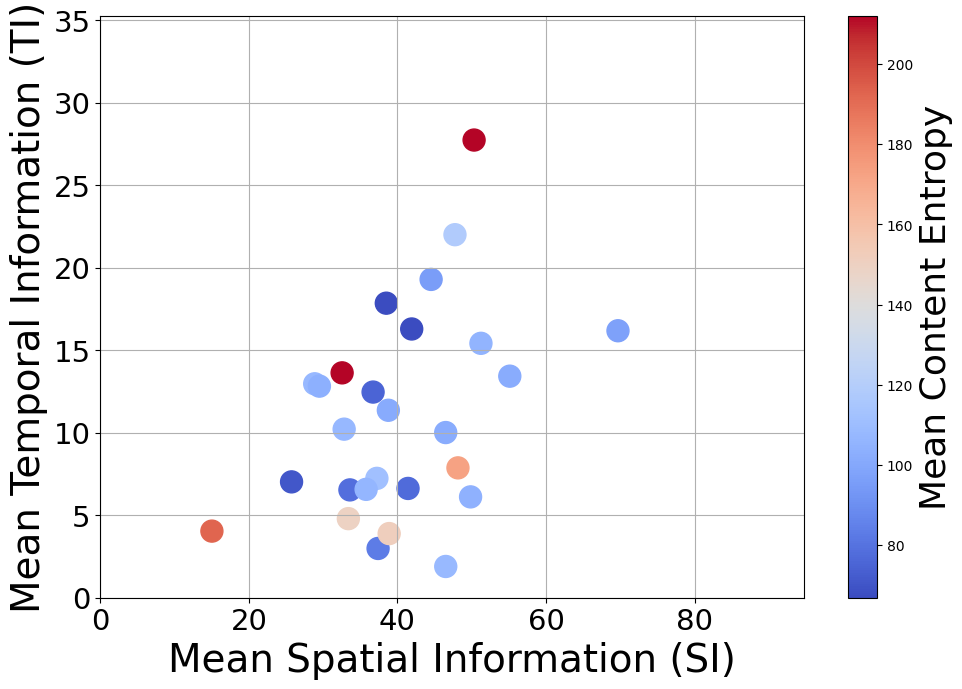

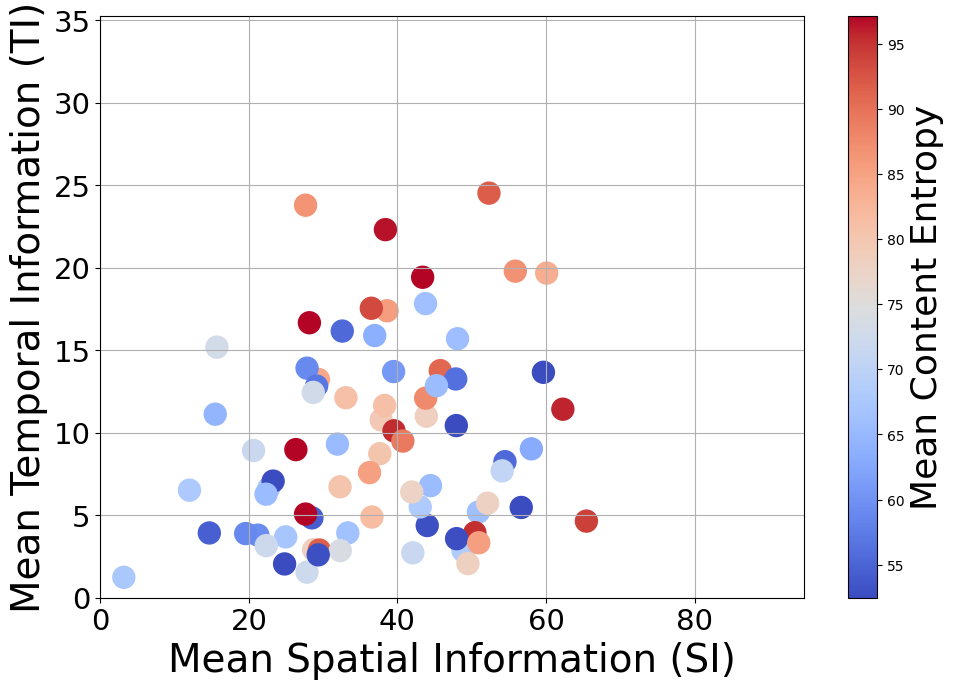

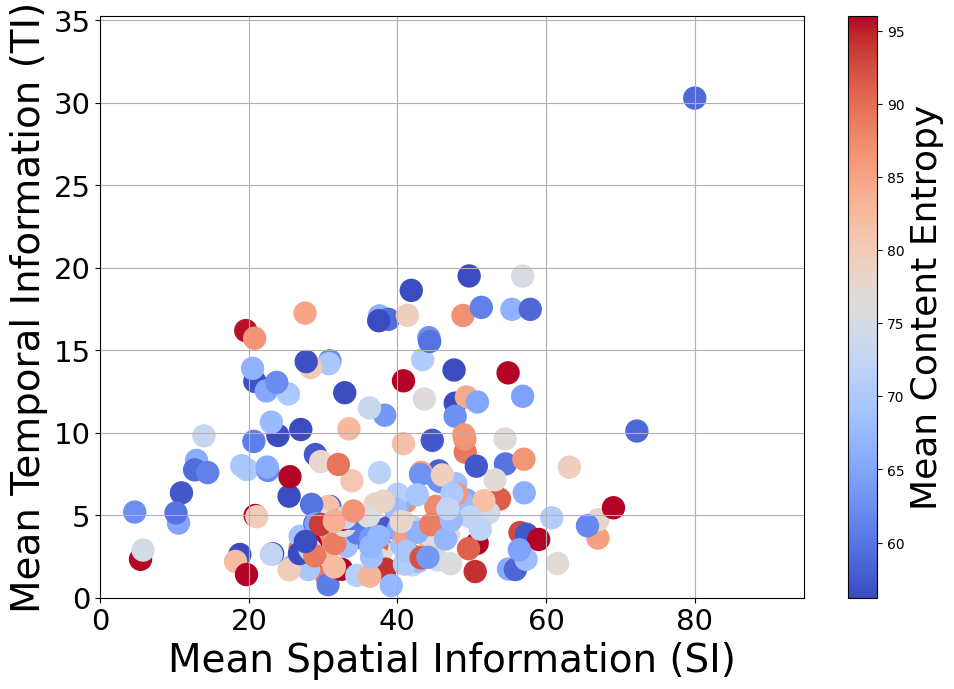

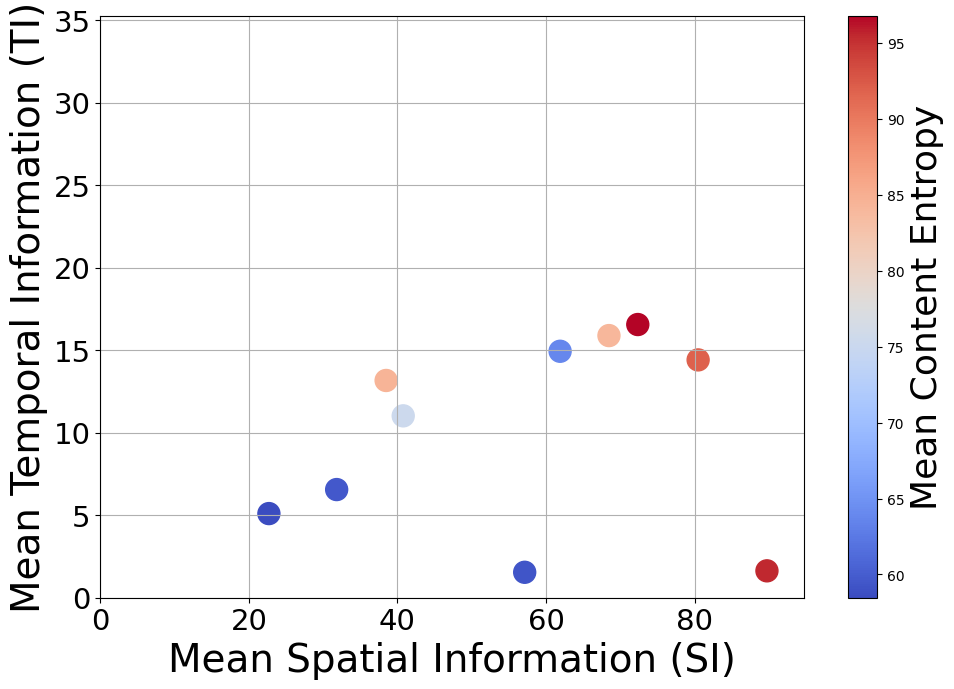

In [113]:
plot_mean_entropy_vs_SITI_alldatasets(datasets_folder,datasets,fontsize=28,markersize=250)

In [114]:
def fetch_entropies(datasets_folder,dataset):
    dataset_folder = os.path.join(datasets_folder, dataset)
    data_path = os.path.join(dataset_folder, 'video_data')
    videos = os.listdir(data_path)
    entropies={}
    aes={}
    IEs={}
    for video in videos:
        entropy_path = os.path.join(data_path, video, f'{video}_content_entropy.npy')
        ae_path=os.path.join(data_path,video, f'{video}_AEs.npy')
        IE_path=os.path.join(data_path, video, f'{video}_IEs.npy')
        entropy=np.load(entropy_path)
        ae=np.load(ae_path)
        ie=np.load(IE_path)
        entropies[video]=entropy
        aes[video]=ae
        IEs[video]=ie
    return entropies,aes,IEs

In [115]:
def plot_mean_AEs_vs_entropy(entropies, aes,dataset,color='blue',fontsize=12,markersize=50):
    mean_entropies = []
    mean_AEs = []
    for video in entropies:
        if np.mean(entropies[video])>200:
            continue
        mean_entropies.append(np.mean(entropies[video]))
        mean_AEs.append(np.mean(aes[video]))
        
    plt.figure(figsize=(8, 6))
    plt.scatter(mean_AEs, mean_entropies, color=color, marker='o',s=markersize)
    #for i, video in enumerate(entropies):
    #    plt.annotate(video, (mean_AEs[i], mean_entropies[i]), fontsize=8)
    #plt.title(f'{dataset} Mean Entropy vs Mean AE')
    plt.xlabel('Mean Actual Entropy',fontsize=fontsize)
    plt.ylabel('Mean Content Entropy',fontsize=fontsize)
    plt.xticks(fontsize=fontsize-7)
    plt.yticks(fontsize=fontsize-7)
    plt.grid(True)
    plots_folder = os.path.join('Plots', 'Entropies')
    os.makedirs(plots_folder, exist_ok=True)
    plot_path = os.path.join(plots_folder, f'{dataset}_contententropy_vs_AE.png')
    plt.savefig(plot_path)
    plt.show()

In [121]:
def plot_mean_AEs_vs_entropy_all_datasets(datasets_folder,datasets,color,dataset_names,fontsize=12,markersize=50):
    global_min_AE, global_max_AE = float('inf'), float('-inf')
    global_min_CE, global_max_CE = float('inf'), float('-inf')
    video_AEs={}
    video_CEs={}
    for idx,dataset in enumerate(datasets):
        ces,aes,_=fetch_entropies(datasets_folder,dataset)
        mean_CEs = []
        mean_AEs = []
        for video in ces:
            if np.mean(ces[video])>150:
                continue
            mean_CE=np.mean(ces[video])
            mean_AE=np.mean(aes[video])
            global_min_AE = min(global_min_AE, mean_AE)
            global_max_AE = max(global_max_AE, mean_AE)
            global_min_CE = min(global_min_CE, mean_CE)
            global_max_CE = max(global_max_CE, mean_CE)
            mean_CEs.append(mean_CE)
            mean_AEs.append(mean_AE)
        video_AEs[dataset]=mean_AEs
        video_CEs[dataset]=mean_CEs
    
    plt.figure(figsize=(8, 6))
    for idx, dataset in enumerate(datasets):
        
        
        plt.scatter(video_AEs[dataset], video_CEs[dataset], color=color[idx], marker='o',label=dataset_names[idx],s=markersize)
        #for i, video in enumerate(entropies):
        #    plt.annotate(video, (mean_AEs[i], mean_entropies[i]), fontsize=8)
    #plt.title(f'{dataset} Mean Entropy vs Mean AE')
    plt.xlabel('Mean AEs',fontsize=fontsize)
    plt.ylabel('Mean Content Entropy', fontsize=fontsize)
    plt.ylim(global_min_CE-2, global_max_CE+2)
    plt.xlim(global_min_AE-0.1, global_max_AE + 0.1)
    plt.xticks(fontsize=fontsize-4)
    plt.yticks(fontsize=fontsize-4)
    plt.legend()
    plt.grid(True)
    plots_folder = os.path.join('Plots', 'Entropies')
    os.makedirs(plots_folder, exist_ok=True)
    plot_path = os.path.join(plots_folder, f'all_datasets_contententropy_vs_AE.png')
    plt.savefig(plot_path)
    plt.show()

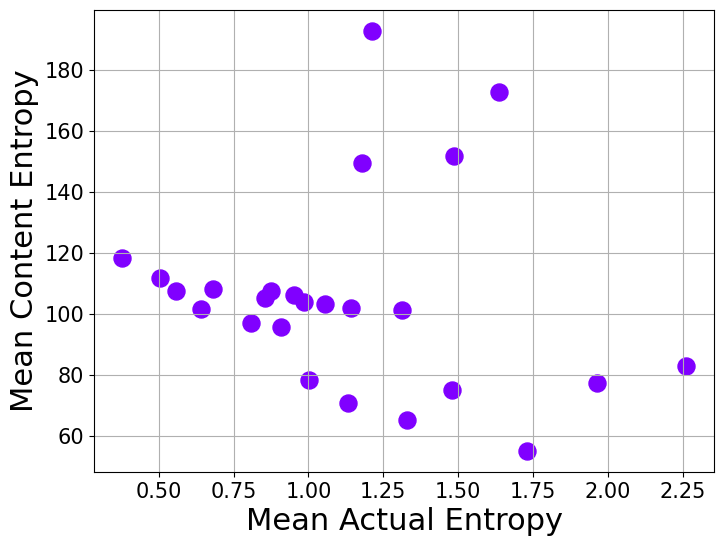

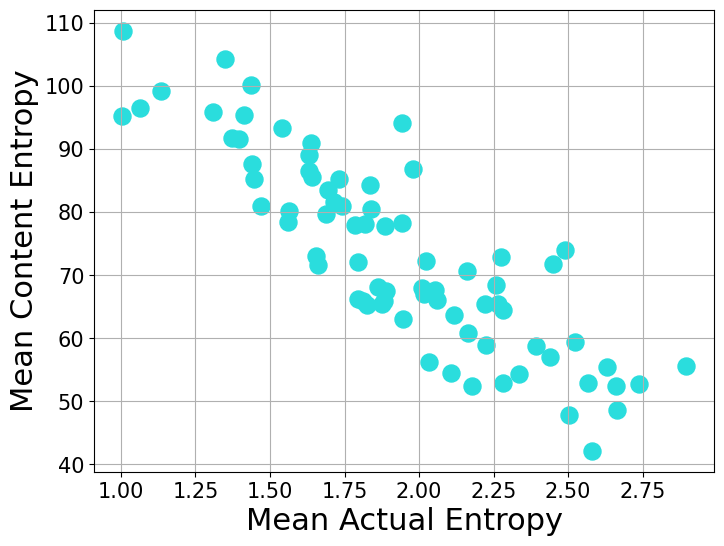

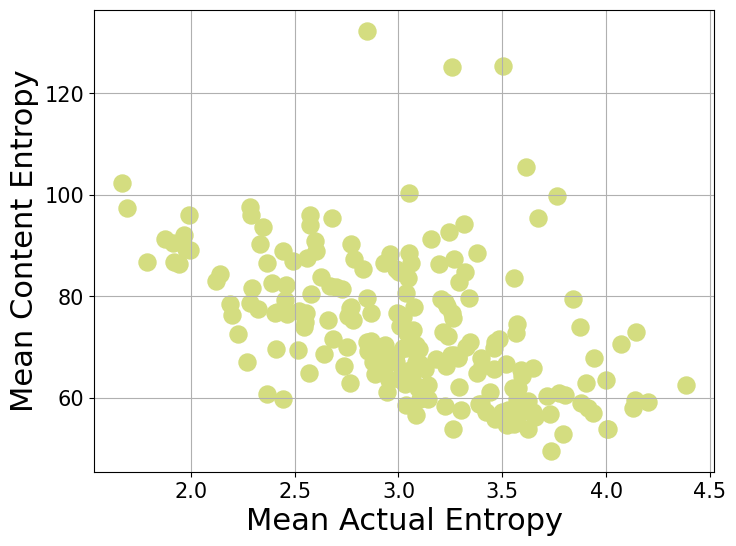

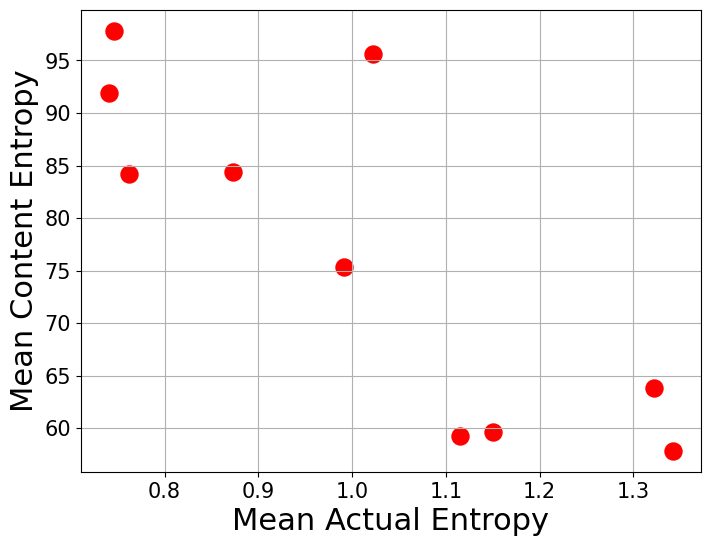

In [118]:
for idx,dataset in enumerate(datasets):
    c_entropies,aes,IEs=fetch_entropies(datasets_folder,dataset)
    plot_mean_AEs_vs_entropy(c_entropies, aes, dataset,color=dataset_colors[idx],fontsize=22,markersize=150)

In [122]:
dataset_names=['MM22','PAMI18','CVPR18','NOSSDAV17']

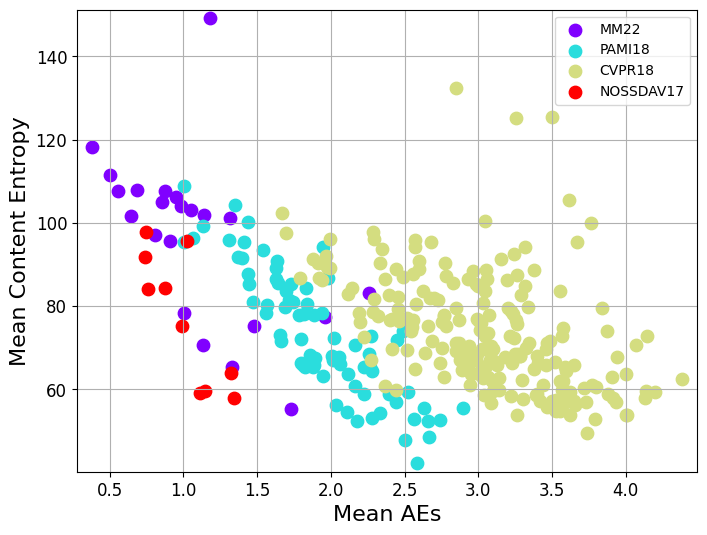

In [123]:
plot_mean_AEs_vs_entropy_all_datasets(datasets_folder,datasets,dataset_colors,dataset_names=dataset_names,fontsize=16,markersize=80)

In [66]:
def plot_train_test(datasets_folder,dataset, ces,aes,fontsize=12,markersize=50):
    dataset_dir=os.path.join(datasets_folder,dataset)
    vid_data_dir=os.path.join(dataset_dir,'video_data')
    split_path=os.path.join(dataset,'splits','test_vids')
    test_vids=load_dict_from_csv(split_path,columns=['video'])
    test_vids=[vid[0] for vid in test_vids]
    all_vids=os.listdir(vid_data_dir)
    train_vids=list(set(all_vids)-set(test_vids))
    
    test_AEs=[]
    test_CEs=[]
    
    for video in test_vids:
        test_CEs.append(np.mean(ces[video]))
        test_AEs.append(np.mean(aes[video]))
     
    train_AEs=[]
    train_CEs=[]    
    for video in train_vids:
        train_CEs.append(np.mean(ces[video]))
        train_AEs.append(np.mean(aes[video]))
        
    plt.figure(figsize=(8, 6))
    plt.scatter(train_AEs, train_CEs, color='blue', marker='o', label='training videos',s=markersize)
    plt.scatter(test_AEs, test_CEs, color='red', marker='o', label='testing videos',s=markersize)
    #for i, video in enumerate(entropies):
    #    plt.annotate(video, (mean_AEs[i], mean_entropies[i]), fontsize=8)
    #plt.title(f'{dataset} Mean Entropy vs Mean AE')
    plt.xlabel('Mean Actual Entropy',fontsize=fontsize)
    plt.ylabel('Mean Content Entropy',fontsize=fontsize)
    plt.xticks(fontsize=fontsize-7)
    plt.yticks(fontsize=fontsize-7)
    plt.grid(True)
    plots_folder = os.path.join('Plots', 'Splits')
    os.makedirs(plots_folder, exist_ok=True)
    plot_path = os.path.join(plots_folder, f'{dataset}_train_test_split.png')
    plt.savefig(plot_path)
    plt.show()

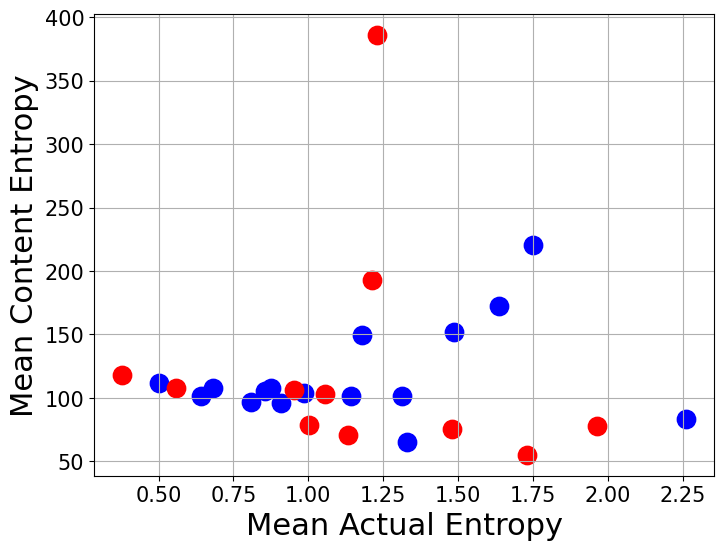

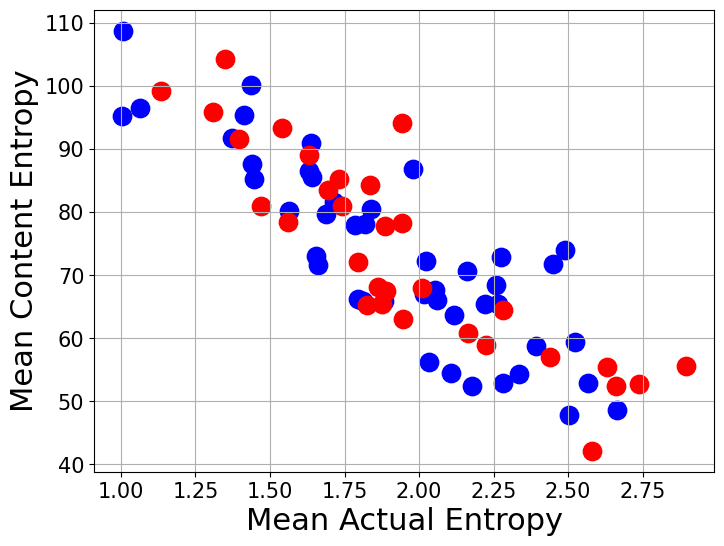

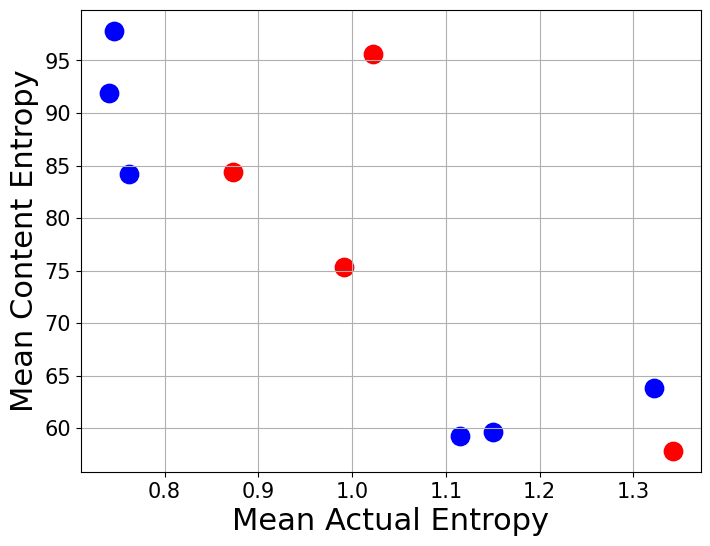

In [126]:
used_datasets=['Jin_22', 'PAMI18', 'Fan_NOSSDAV_17']
for idx,dataset in enumerate(used_datasets):
    ces,aes,IEs=fetch_entropies(datasets_folder,dataset)
    plot_train_test(datasets_folder,dataset,ces,aes,fontsize=22,markersize=175)

In [68]:
datasets

['Jin_22', 'PAMI18', 'CVPR18', 'Fan_NOSSDAV_17']

In [88]:
test='TRACK__init_5_in_5_out_25_end_25_Epoch500'

In [69]:
def get_model_name(model):
    model=model.split('_')
    if model[0]=='pos':
        model_name='pos_only'
    else:
        model_name=model[0]
    if model_name=='DVMS':
        model_name=model_name+'_'+model[-2][0]+'='+model[-2][1:]
    return model_name

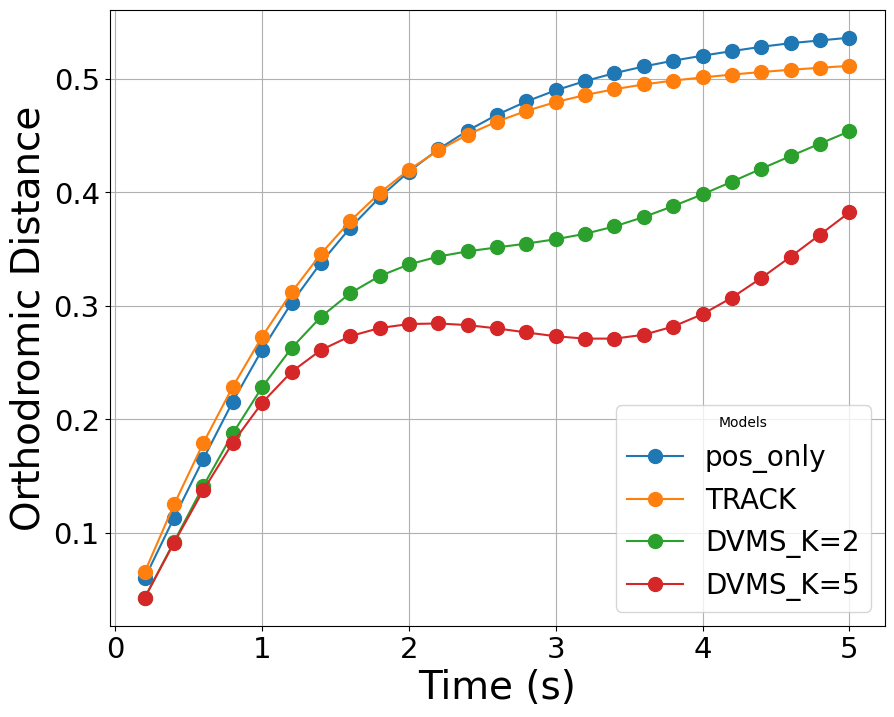

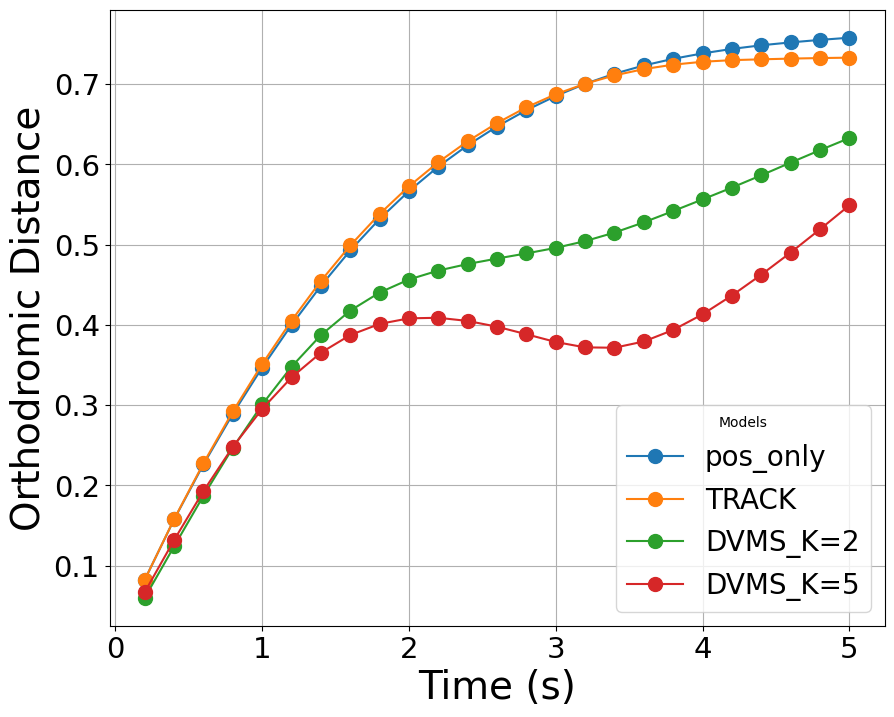

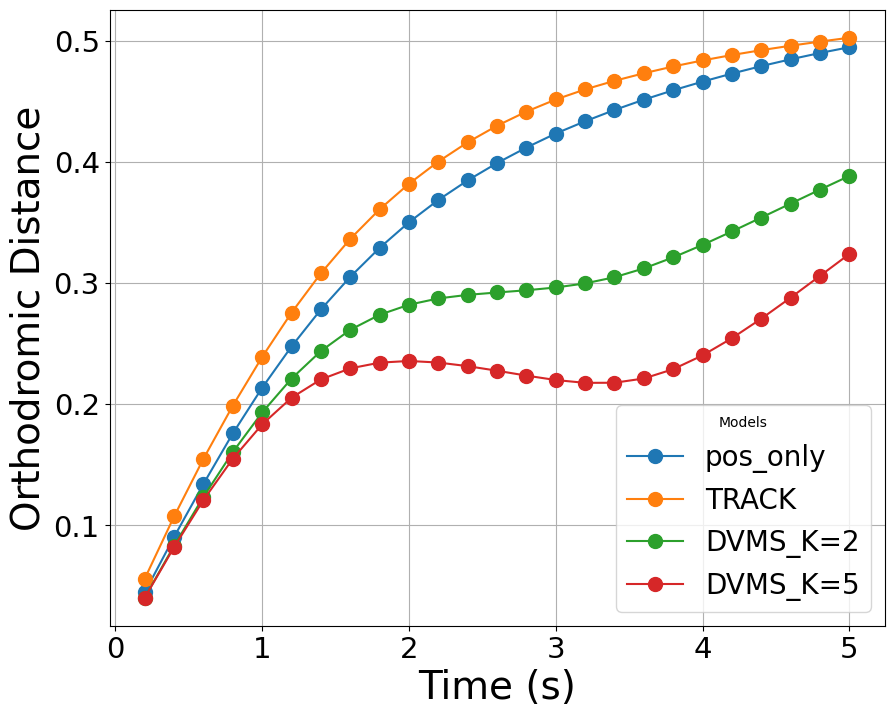

In [143]:
plot_paths='TestPlots'
datasets=os.listdir(plot_paths)
dataset_names=['PAMI18','NOSSDAV17','MM22']
fontsize=28
markersize=10
for idx,dataset in enumerate(datasets):
    paths=os.path.join(plot_paths,dataset)
    models=os.listdir(paths)
    model_dist_values = {}
    model_names=[get_model_name(model) for model in models]
    for model,model_name in zip(models,model_names):
        model_path=os.path.join(paths,model)
        dist_values_path=os.path.join(model_path,'orth_dist_values.npy')
        if os.path.exists(dist_values_path):
            # Load the dist_values from the file
            dist_values = np.load(dist_values_path)
            
            # Store dist_values in the dictionary with model name as key
            model_dist_values[model_name] = dist_values
        else:
            print(f"File {dist_values_path} does not exist.")

    reordered=['pos_only','TRACK','DVMS_K=2','DVMS_K=5']
    reordered_values={key: model_dist_values[key] for key in reordered}
    
    if reordered_values:
        # Generate the timestamps based on 5fps
        timestamps = np.arange(0.2, 5.1, 0.2)  # Adjust according to your timestamp range and fps
        
        # Plotting
        plt.figure(figsize=(10, 8))
        # Plot each model's dist_values with a label
        for model_name, dist_values in reordered_values.items():
            #model_name=get_model_name(model)
            plt.plot(timestamps, dist_values, marker='o', linestyle='-', label=model_name,markersize=markersize)
        
        #plt.title(f'Dataset: {dataset_names[idx]} - Orthodromic Distance Across Models')
        plt.xlabel('Time (s)',fontsize=fontsize)
        plt.ylabel('Orthodromic Distance',fontsize=fontsize)
        plt.legend(title='Models',fontsize=fontsize-8)
        plt.xticks(fontsize=fontsize-7)
        plt.yticks(fontsize=fontsize-7)
        
        plt.grid(True)
        plots_folder = os.path.join('Plots', 'Model_Performances')
        os.makedirs(plots_folder, exist_ok=True)
        # Save plot to the dataset path
        plot_file = os.path.join(plots_folder, f'{dataset}_model_dist_values.png')
        plt.savefig(plot_file)
        plt.show()
        plt.close()
        
        #print(f"Plot saved at: {plot_file}")
    else:
        print(f"No dist_values found for dataset: {dataset}")

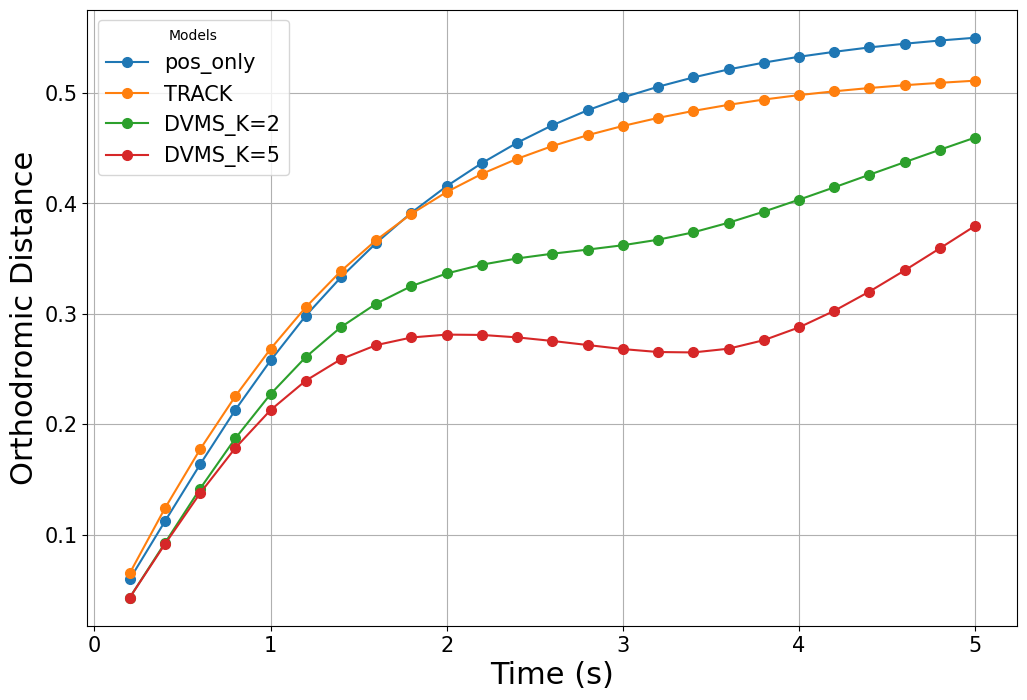

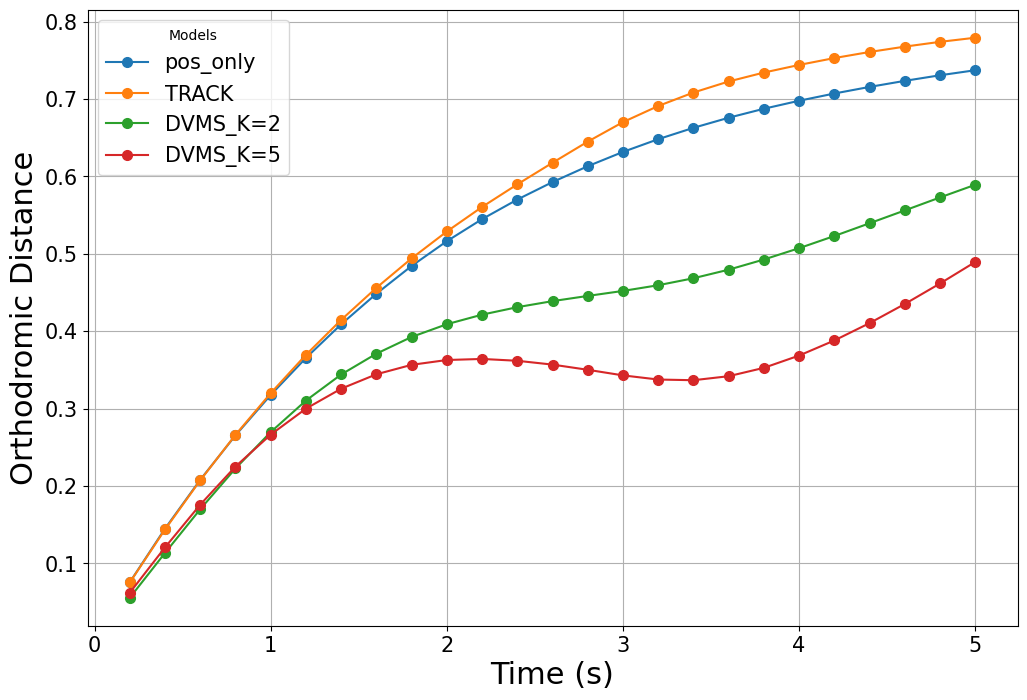

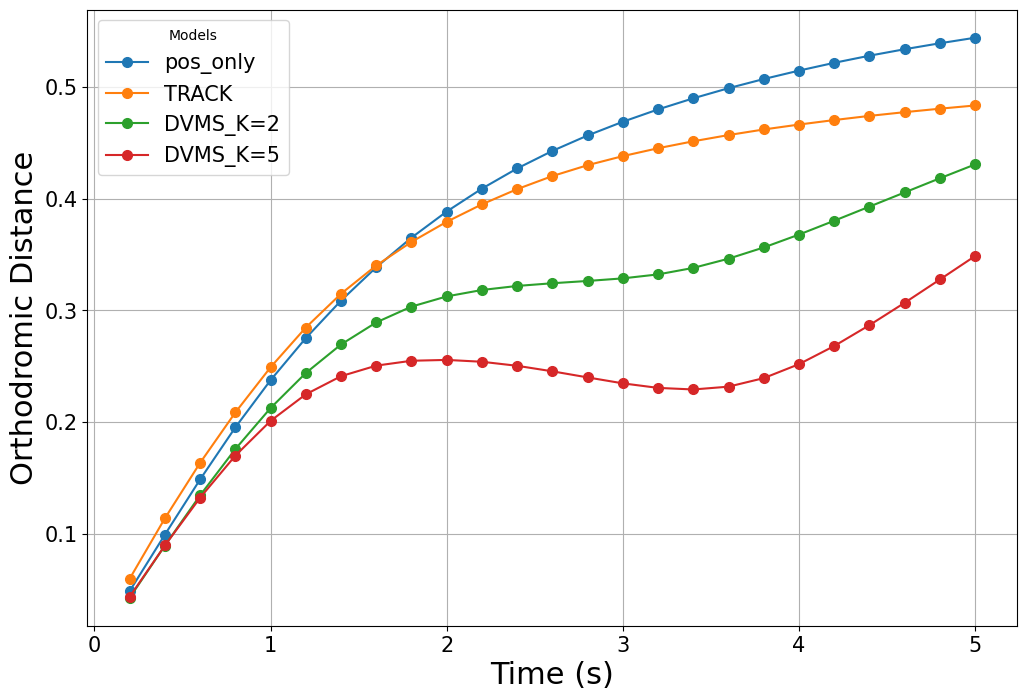

In [100]:
plot_paths='New_User_TestPlots'
datasets=os.listdir(plot_paths)
dataset_names=['PAMI18','NOSSDAV17','MM22']
fontsize=22
for idx,dataset in enumerate(datasets):
    paths=os.path.join(plot_paths,dataset)
    models=os.listdir(paths)
    model_dist_values = {}
    model_names=[get_model_name(model) for model in models]
    for model,model_name in zip(models,model_names):
        model_path=os.path.join(paths,model)
        dist_values_path=os.path.join(model_path,'orth_dist_values.npy')
        if os.path.exists(dist_values_path):
            # Load the dist_values from the file
            dist_values = np.load(dist_values_path)
            
            # Store dist_values in the dictionary with model name as key
            model_dist_values[model_name] = dist_values
        else:
            print(f"File {dist_values_path} does not exist.")

    reordered=['pos_only','TRACK','DVMS_K=2','DVMS_K=5']
    reordered_values={key: model_dist_values[key] for key in reordered}
    
    if reordered_values:
        # Generate the timestamps based on 5fps
        timestamps = np.arange(0.2, 5.1, 0.2)  # Adjust according to your timestamp range and fps
        
        # Plotting
        plt.figure(figsize=(12, 8))
        # Plot each model's dist_values with a label
        for model_name, dist_values in reordered_values.items():
            #model_name=get_model_name(model)
            plt.plot(timestamps, dist_values, marker='o', linestyle='-', label=model_name, markersize=7)
        
        #plt.title(f'Dataset: {dataset_names[idx]} - Orthodromic Distance Across Models')
        plt.xlabel('Time (s)',fontsize=fontsize)
        plt.ylabel('Orthodromic Distance',fontsize=fontsize)
        plt.legend(title='Models',fontsize=fontsize-7)
        plt.grid(True)
        plots_folder = os.path.join('Plots', 'Model_Performances')
        os.makedirs(plots_folder, exist_ok=True)
        # Save plot to the dataset path
        plot_file = os.path.join(plots_folder, f'{dataset}_model_dist_values_new_user.png')
        plt.xticks(fontsize=fontsize-7)
        plt.yticks(fontsize=fontsize-7)
        #plt.savefig(plot_file)
        plt.show()
        plt.close()
        
        #print(f"Plot saved at: {plot_file}")
    else:
        print(f"No dist_values found for dataset: {dataset}")

In [77]:
def generate_unique_colors(n_colors):
    """
    Generate a list of unique colors.
    :param n_colors: Number of unique colors needed
    :return: List of unique colors
    """
    colormap = plt.get_cmap('tab20')  # You can choose a different colormap if needed
    colors = [colormap(i / n_colors) for i in range(n_colors)]
    return colors

In [95]:
def plot_combined_distances_for_model(dist_values_per_video, video_colors, model, ax,dataset,fontsize=22, markersize=10):
    """Plot combined orthodromic distances for all videos in a model."""
    timestamps = np.arange(0.2, 5.1, 0.2)  # 0.2 to 5 seconds with 5 fps
    
    for video, dist_values in dist_values_per_video.items():
        color = video_colors.get(video, 'black')  # Default to 'black' if video color not found
        ax.plot(timestamps, dist_values, marker='o', linestyle='-', color=color, label=video,markersize=markersize)
    
    #ax.set_title(f'Model: {model} - Orthodromic Distances Across Videos for {dataset}')
    ax.set_xlabel('Time (s)',fontsize=22)
    ax.set_ylabel('Orthodromic Distance',fontsize=22)
    ax.legend(loc='best',fontsize=fontsize-7)
    
    #ax.grid(True)

In [96]:
vid_plot_paths='Test_vid_plots'

In [212]:

def plot_video_charts(dataset, markersize=7,fontsize=22):
    paths=os.path.join(vid_plot_paths,dataset)
    models=os.listdir(paths)
    models=['DVMS__init_5_in_5_out_25_end_25_K5_Epoch500']
    temp_path=os.path.join(paths,models[0])
    output_path=os.path.join('Plots','PerVideo_test')
    os.makedirs(output_path, exist_ok=True)
    videos=os.listdir(temp_path)
    # Generate unique colors
    num_videos = len(videos)
    colors = generate_unique_colors(num_videos)
    # Create a mapping of videos to colors
    video_colors = dict(zip(videos, colors))
    #entropies,aes,IEs=fetch_entropies(datasets_folder,dataset,videos)
    #fig=plot_mean_AEs_vs_entropy(entropies,aes,dataset, video_colors)
    model_dist_values={}
    for model in models:
        model_path=os.path.join(paths,model)
        
        for video in videos:
            video_path=os.path.join(model_path,video)
            #print(video_path)
            dist_values_path=os.path.join(video_path,'orth_dist_values.npy')
            if os.path.exists(dist_values_path):
                # Load the dist_values from the file
                dist_values = np.load(dist_values_path)
                if model not in model_dist_values:
                        model_dist_values[model] = {}
                # Store dist_values in the dictionary with model name as key
                model_dist_values[model][video] = dist_values
            else:
                print(f"File {dist_values_path} does not exist.")
    for model, dist_values_per_video in model_dist_values.items():
            fig, ax = plt.subplots(figsize=(9, 7))
            plot_combined_distances_for_model(dist_values_per_video, video_colors, model, ax, dataset)
            
            plot_file = os.path.join(output_path, f'{dataset}_{model}_combined_distances.png')
            plt.tight_layout()
            plt.xticks(fontsize=fontsize-7)
            plt.yticks(fontsize=fontsize-7)
            ax.legend(loc='best',fontsize=fontsize-7)
            plt.savefig(plot_file)
            
            plt.show()
            
            #print(f"Combined distances plot saved at: {plot_file}")
    
    

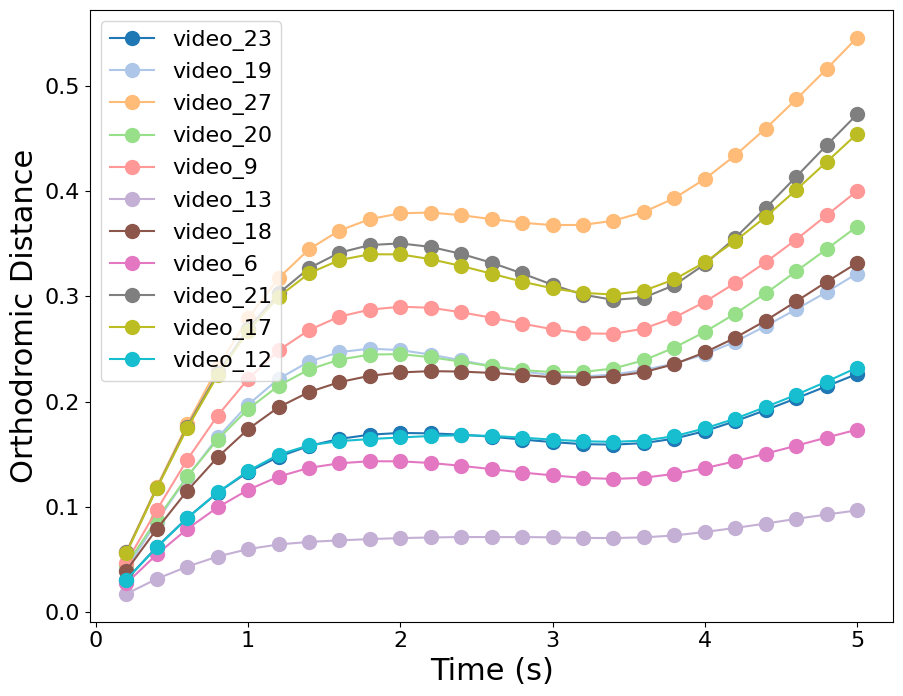

In [213]:
plot_video_charts('Jin_22',markersize=7,fontsize=23)

In [175]:
def fetch_entropies(datasets_folder,dataset, videos):
    dataset_folder = os.path.join(datasets_folder, dataset)
    #video_img_folder = os.path.join(dataset_folder, '5fps_Video_Images')
    data_path = os.path.join(dataset_folder, 'video_data')
    #videos = os.listdir(video_img_folder)
    entropies={}
    aes={}
    IEs={}
    for video in videos:
        entropy_path = os.path.join(data_path, video, f'{video}_content_entropy.npy')
        ae_path=os.path.join(data_path,video, f'{video}_AEs.npy')
        IE_path=os.path.join(data_path, video, f'{video}_IEs.npy')
        entropy=np.load(entropy_path)
        ae=np.load(ae_path)
        ie=np.load(IE_path)
        entropies[video]=entropy
        aes[video]=ae
        IEs[video]=ie
    return entropies,aes,IEs

In [184]:
timestamps = np.arange(0.2, 5.1, 0.2)
def plot_test_entropies(dataset,scale=100,fontsize=22,markersize=80):
    paths=os.path.join(vid_plot_paths,dataset)
    models=os.listdir(paths)
    temp_path=os.path.join(paths,models[0])
    videos=os.listdir(temp_path)
    # Generate unique colors
    num_videos = len(videos)
    colors = generate_unique_colors(num_videos)
    # Create a mapping of videos to colors
    video_colors = dict(zip(videos, colors))
    entropies,aes,IEs=fetch_entropies(datasets_folder,dataset,videos)
    fig=plot_mean_AEs_vs_entropy(entropies,aes, IEs, dataset, video_colors,scale,fontsize=fontsize)

In [204]:
def plot_mean_AEs_vs_entropy(entropies, aes, ies, dataset, video_colors, scale=100,fontsize=22):
    mean_entropies = []
    mean_AEs = []
    fig, ax = plt.subplots(figsize=(8, 6))
    mean_IEs=[np.mean(ies[video]) for video in ies]
    min_IE = min(mean_IEs)
    max_IE = max(mean_IEs)
    video_data = []  # List to store (video, mean_AE, color)
    for video,color in video_colors.items():
        mean_entropies.append(np.mean(entropies[video]))
        mean_AEs.append(np.mean(aes[video]))
        mean_entropy = np.mean(entropies[video])
        mean_AE = np.mean(aes[video])
        mean_IE=np.mean(ies[video])
        if max_IE != min_IE:  # Avoid division by zero
            marker_size = 1 + 9 * (mean_IE - min_IE) / (max_IE - min_IE)
        else:
            marker_size = 1 
        marker_size=marker_size*scale
        ax.scatter(mean_AE, mean_entropy, color=color, marker='o', label=video,s=marker_size)
        video_data.append((video, mean_AE, color))
        #ax.annotate(video, (mean_AE, mean_entropy), fontsize=8, ha='left', color='black',xytext=offset,textcoords='offset points')
    
    #plt.figure(figsize=(8, 6))
    #plt.scatter(mean_AEs, mean_entropies, color=color, marker='o')
    #for i, video in enumerate(entropies):
    #    plt.annotate(video, (mean_AEs[i], mean_entropies[i]), fontsize=8)
    #plt.title(f'Test videos {dataset} Mean Entropy vs Mean AE')
    #plt.xlabel('Mean AEs')
    #plt.ylabel('Mean Content Entropy')
    #plt.grid(True)
    #plots_folder = os.path.join('Plots', 'Entropies')
    #os.makedirs(plots_folder, exist_ok=True)not 
    #plot_path = os.path.join(plots_folder, f'{dataset}_contententropy_vs_AE.png')
    #plt.savefig(plot_path)
    # Create a new figure and axis
    video_data.sort(key=lambda x: x[1], reverse=True)
    plot_dir=os.path.join('Plots','PerVideo_dist')
    os.makedirs(plot_dir, exist_ok=True)
    output_path=os.path.join(plot_dir,f'{dataset}_per_video_ce_ae.png')
    
    #mean_dist_values=
    # Plot the data
    #ax.set_title(f'Test videos {dataset} Mean Entropy vs Mean AE')
    ax.set_xlabel('Mean AEs',fontsize=fontsize)
    ax.set_ylabel('Mean Content Entropy',fontsize=fontsize)
    handles = [
        plt.Line2D(
            [0], [0], 
            marker='o', 
            color='w', 
            markerfacecolor=color, 
            markersize=10, 
            label=video
        ) 
        for video, _, color in video_data
    ]
    
    ax.legend(handles=handles, fontsize=fontsize-8, title='Videos', title_fontsize=fontsize-7)
    ax.grid(True)
    plt.xticks(fontsize=fontsize-7)
    plt.yticks(fontsize=fontsize-7)
    plt.savefig(output_path)
    
    # Return the figure
    return fig
    #return plt

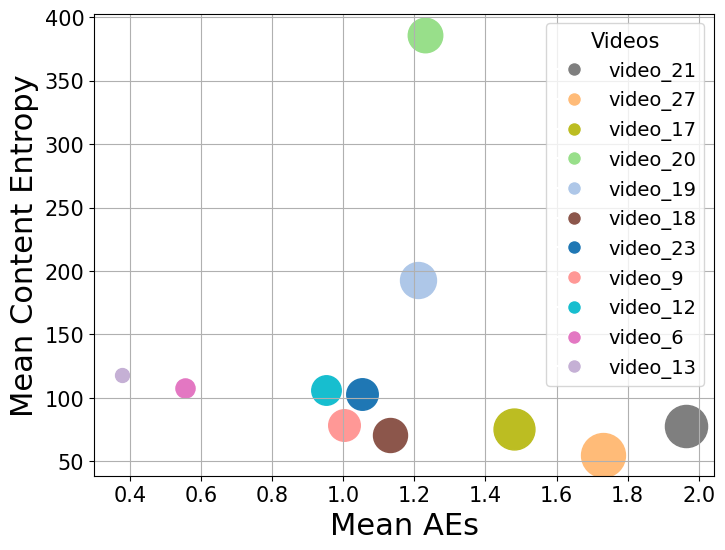

In [205]:
plot_test_entropies('Jin_22',scale=100)

In [214]:
data_path='Plots/Full_video_plots'
datasets=os.listdir(data_path)

['PAMI18', 'Fan_NOSSDAV_17', 'Jin_22']


In [272]:
def fetch_user_list(datasets_folder,dataset,videos):
    users={}
    for video in videos:
        data_path=os.path.join(datasets_folder,dataset,'video_data',video)
        users[video]=np.load(os.path.join(data_path,f'{video}_users.npy'))
    return users

In [284]:
def get_user_IE(vid_IEs,vid_users,username):
    user_index = np.where(vid_users == username)[0][0]
    user_IE=vid_IEs[user_index]
    return user_IE

def fetch_timestamps(datasets_folder,dataset,videos):
    tstamps={}
    for video in videos:
        data_path=os.path.join(datasets_folder,dataset,'video_data',video)
        tstamps[video]=np.load(os.path.join(data_path,f'{video}_timestamps.npy'))
    return tstamps

In [311]:
from scipy.signal import find_peaks

In [322]:
def plot_individual_performance(data_path,dataset,fontsize=22,markersize=10):
    models=os.listdir(os.path.join(data_path,dataset))
    
    for model in models:
        vid_path=os.path.join(data_path,dataset,model)
        videos=os.listdir(vid_path)
        entropies,aes,IEs=fetch_entropies(datasets_folder,dataset,videos)
        #print(IEs['ride'].shape)
        all_users=fetch_user_list(datasets_folder,dataset,videos)
        timestamps=fetch_timestamps(datasets_folder,dataset,videos)
        #print(users)
        #return 0
        for video in videos:
            user_path=os.path.join(vid_path,video)
            users=os.listdir(user_path)
            vid_CEs=entropies[video][1:]
            vid_IEs=IEs[video]

            vid_users=all_users[video]
            vid_timestamps=timestamps[video][1:]
            for user in users:
                user_IE=get_user_IE(vid_IEs,vid_users,user)[1:]
                
                result_path=os.path.join(user_path,user)
                dist_next_values=np.load(os.path.join(result_path,'orth_dist_next_values.npy'))
                
                dist_1_values=np.load(os.path.join(result_path,'orth_dist_1_values.npy'))
                dist_2_values=np.load(os.path.join(result_path,'orth_dist_2_values.npy'))
                dist_3_values=np.load(os.path.join(result_path,'orth_dist_3_values.npy'))
                dist_4_values=np.load(os.path.join(result_path,'orth_dist_4_values.npy'))
                dist_5_values=np.load(os.path.join(result_path,'orth_dist_5_values.npy'))
                timestamps_next=timestamps_next = np.arange(5, 5 + len(dist_next_values) * 1) / 5
                print(len(timestamps_next))
                timestamps_1 = np.arange(9, 9 + len(dist_1_values) * 1) / 5  # 1s intervals
                #timestamps_2 = np.arange(14, 14 + len(dist_2_values) * 5, 5) / 5
                timestamps_3 = np.arange(19, 19 + len(dist_3_values) * 1) / 5
                #timestamps_4 = np.arange(24, 24 + len(dist_4_values) * 5, 5) / 5
                timestamps_5 = np.arange(29, 29 + len(dist_5_values) * 1) / 5
                
                
                peaks_dist_5,_=find_peaks(dist_5_values)
                peaks_vid_CE, _ = find_peaks(vid_CEs)

                # Get the peak timings
                peak_times_dist_5 = timestamps_5[peaks_dist_5]
                peak_times_vid_CE = vid_timestamps[peaks_vid_CE]
                """ plt.figure(figsize=(14, 8))
                plt.plot(vid_timestamps, user_IE, marker='o', label='User_IE')
                plt.plot(vid_timestamps, vid_CEs, marker='o', label='Vid_CE')
                # Plotting each distance set
                plt.plot(timestamps_next, dist_next_values, marker='o', label='Dist Next (0.2s)')
                plt.plot(timestamps_1, dist_1_values, marker='o', label='Dist 1 (1s)')
                #plt.plot(timestamps_2, dist_2_values, marker='o', label='Dist 2 (2s)')
                plt.plot(timestamps_3, dist_3_values, marker='o', label='Dist 3 (3s)')
                #plt.plot(timestamps_4, dist_4_values, marker='o', label='Dist 4 (4s)')
                plt.plot(timestamps_5, dist_5_values, marker='o', label='Dist 5 (5s)')

                plt.title(f'Performance Over Time for {model} - {video} - {user}', fontsize=fontsize)
                plt.xlabel('Time (seconds)', fontsize=fontsize)
                plt.ylabel('Distance Values', fontsize=fontsize)
                plt.grid(True)
                plt.legend(fontsize=fontsize-4)
                plt.xticks(fontsize=fontsize-4)
                plt.yticks(fontsize=fontsize-4) """
                # Create a figure and axis
                fig, ax1 = plt.subplots(figsize=(14, 8))

                # Plotting user_IE and distance values on the primary y-axis
                #ax1.plot(vid_timestamps, user_IE, marker='o', label='User_IE')
                #ax1.plot(timestamps_next, dist_next_values, marker='o', label='Dist Next (0.2s)')
                #ax1.plot(timestamps_1, dist_1_values, marker='o', label='Dist 1 (1s)')
                #ax1.plot(timestamps_3, dist_3_values, marker='o', label='Dist 3 (3s)')
                #ax1.plot(timestamps_5, dist_5_values, marker='o', label='Dist 5 (5s)')
                plt.plot(peak_times_dist_5, dist_5_values[peaks_dist_5], 'rx', label='Dist 5 Peaks')

                # Set labels and title for the primary y-axis
                ax1.set_xlabel('Time (seconds)', fontsize=fontsize)
                ax1.set_ylabel('Distance Values', fontsize=fontsize)
                ax1.set_title(f'Performance Over Time for {model} - {video} - {user}', fontsize=fontsize)
                ax1.grid(True)
                ax1.legend(fontsize=fontsize-4)
                ax1.tick_params(axis='y', labelsize=fontsize-4)
                ax1.tick_params(axis='x', labelsize=fontsize-4)

                # Create a secondary y-axis for vid_CEs
                ax2 = ax1.twinx()
                #ax2.plot(vid_timestamps, vid_CEs, marker='o', color='orange', label='Vid_CE')
                plt.plot(peak_times_vid_CE, vid_CEs[peaks_vid_CE], 'rx',color=
                         'orange', label='Vid_CE Peaks')

                ax2.set_ylabel('Vid_CE Values', fontsize=fontsize)
                ax2.legend(fontsize=fontsize-4, loc='upper right')
                ax2.tick_params(axis='y', labelsize=fontsize-4)

                plt.show()
                return

                

271


/tmp/ipykernel_305737/1448830783.py:88: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "rx" (-> color='r'). The keyword argument will take precedence.
  plt.plot(peak_times_vid_CE, vid_CEs[peaks_vid_CE], 'rx',color=


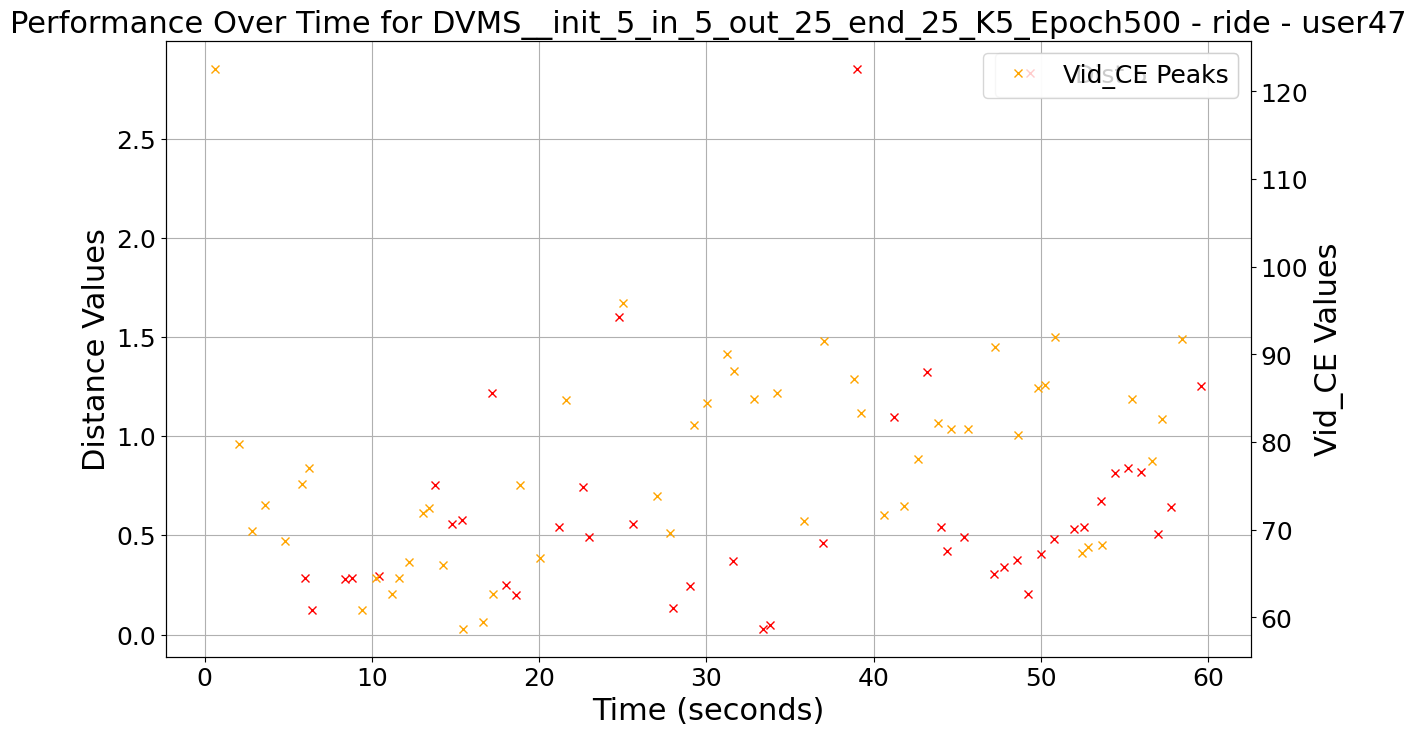

In [323]:
plot_individual_performance(data_path,datasets[1])